In [2]:
def stereo_to_mono(audio):
    return audio.sum(axis=1) / 2

In [3]:
frq, raw_sample = read("oblivion.wav")
original = stereo_to_mono(raw_sample)

In [4]:
frq, raw_sample = read("oblivion.cut.wav")
sample = stereo_to_mono(raw_sample)

In [5]:
noise = np.random.normal(0, 1, sample.shape)
len(noise)

959488

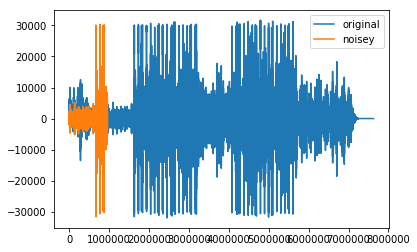

In [6]:
original_l, = plt.plot(original, label="original")
sample_l, = plt.plot(sample + noise, label="noisey sample")
plt.legend([original_l, sample_l], ["original", "noisey"])
plt.show()

In [7]:
class AudioClip(object):
    def __init__(self, data, frq):
        self.data = data
        self.frq = frq
        
    def __get_item__(self, i):
        return self.data[i]
    
    def low_pass(self, cutoff_frq, nyq_freq, order=4):
        normal_cutoff = float(cutoff_frq) / nyq_freq
        b, a = signal.butter(order, normal_cutoff, btype='lowpass', output='ba')
        y = signal.filtfilt(b, a, self.data)
        self.data = y
    
    def filter_and_downsample(self, ds_factor=4):
        self.data = signal.decimate(self.data, ds_factor, n=4)
        self.frq = self.frq / ds_factor
    
#     def create_window(self, bin_num, total_width, seconds=0.1):
#         bin_size = int(self.frq * seconds)
#         frame = np.hanning(bin_size)
#         left_pad = np.zeros(bin_num * bin_size)
#         right_pad = np.zeros(total_width - ((bin_num + 1) * bin_size))
#         window = np.concatenate((left_pad, frame, right_pad), axis=0)
#         return window
    
#     def apply_window(self, bin_num):
#         window = self.create_window(bin_num, len(data))
#         return self.data * window
    
#     def zero_pad(self, records):
#         x = len(records)
#         zeroes = pow(2, math.ceil(math.log(x) / math.log(2))) - x
#         return np.concatenate((records, [0] * zeroes))
    def get_snippet(self, bin_num, bin_size):
        # For sampling frequency 12kHz and 0.1s window
        # bin 0 should return 0 through 1199
        # bin 1 should return 1200 through 2400
        idx = bin_num * bin_size
        snippet = self.data[idx:idx+bin_size]
        assert len(snippet) == bin_size
        return snippet
    
    def multiply_hamming(self, snippet, bin_size):
        # Better than hanning window
        # plt.plot(np.hanning(bin_size) * np.array(snippet))
        return np.hamming(bin_size) * np.array(snippet)
    
    def discard_symmetry(self, frequencies):
        half = len(frequencies) // 2
        return frequencies[:half]
    
    def create_frequencies_array(self, bin_seconds=0.1):
        bin_size = int(self.frq * bin_seconds)
        num_bins = len(self.data) // bin_size
        results = []
        windowed_snippets = []
        magnitudes = []
        for b in range(num_bins):
            # values = apply_window(data, frq, bin_num)
            # padded_values = zero_pad(values)
            # padding gives you better resolution, but too expensive
            # more spectral leakage w/o padding
            snippet = self.get_snippet(b, bin_size)
            windowed_snippet = self.multiply_hamming(snippet, bin_size)
            windowed_snippets.append(windowed_snippet)
            # Can also use Hermitian to speed up
            transform = self.discard_symmetry(np.fft.fft(windowed_snippet))
            results.append(transform)
            magnitude = [abs(x) for x in transform]
            magnitudes.append(magnitude)
        return magnitudes, windowed_snippets, results
    
    def __str__(self):
        return "Size %d sampled at %d Hz" % (len(self.data), self.frq)

In [8]:
ac = AudioClip(original, frq)
print(ac)
ac.low_pass(5000, 2 * 5000) # Cut at 5kHz
ac.filter_and_downsample()

Size 7627232 sampled at 48000 Hz


/Users/kitty/miniconda3/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/Users/kitty/miniconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


In [9]:
print(ac)

Size 1906808 sampled at 12000 Hz


In [10]:
magnitudes, windowed_snippets, results = ac.create_frequencies_array()

1589 600


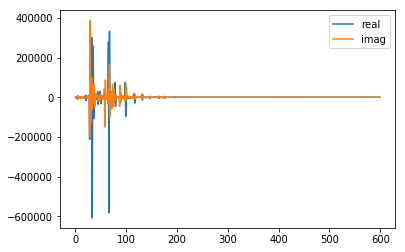

In [11]:
# Frequency went from 44.1kHz to 11.025kHz
print(len(results), len(results[0]))
np.mean(results[1500])
plt.plot([x.real for x in results[701]])
plt.plot([x.imag for x in results[701]])
plt.legend(['real', 'imag'])
plt.show()

In [12]:
def create_gif(file, title, results, xlabel="", ylabel=""):
    ims = []
    fig = plt.figure()
    plt.gca().set_title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    color = random.randint(50, 200) / 255, random.randint(50, 200) / 255, random.randint(50, 200) / 255
    for result in results:
        ims.append(plt.plot(result, color=color))
    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=500, repeat=True)
    writer = PillowWriter(fps=50)
    ani.save(file, writer=writer)
    plt.show()

In [ ]:
create_gif("magnitude.gif", "Magnitude of frequency response over time (0.1s step)", magnitudes, xlabel="Frq (Hz)", ylabel="Magnitude")

In [ ]:
create_gif("windowed.gif", "Windows in time domain over time (0.1s step)", windowed_snippets, xlabel="Frq (Hz)", ylabel="Window")

In [ ]:
create_gif("results.gif", "Results in the time domain (0.1s step)", results, xlabel="Frq (Hz)", ylabel="Results")

In [13]:
class Spectrogram:
    def __init__(self, frq, data):
        self.frq = frq
        self.data = data
        self.bins = []
        self.populate()
        
    def populate(self):
        all_bins = []
        for d in self.data:
            all_bins.append(FrequencyBin(self.frq, d))
        self.bins = self.get_loud_bins(all_bins)
            
    def print_bins(self):
        for b in self.bins:
            print(b.save_above_threshold(), b.calc_threshold(b.get_max_per_level()))
            
    def get_loud_bins(self, all_bins):
        return [b.save_above_threshold() for b in all_bins]

    def make_pairs_dict(self, title, artist, anchor_lead=3, target_size=5):
        ordering = self.get_bin_ordering()
        pairs = {}
        for a in range(len(self.bins) - anchor_lead - target_size):
            anchor_time = ordering[a][0]
            anchor_frq = ordering[a][1]
            t_0 = a + anchor_lead
            for target in ordering[t_0:t_0+target_size]:
                target_time = target[0]
                target_frq = target[1]
                delta_t = target_time - anchor_time
                pairs[(anchor_frq, target_frq, delta_t)] = anchor_time, title, artist
        return pairs

    def get_bin_ordering(self):
        ordering = []
        for f, bin_nums in zip([x / 10.0 for x in range(0, len(self.bins))], self.bins):
            for bin_num in bin_nums:
                x = Decimal(f).quantize(Decimal('0.1'))
                y = Decimal(bin_num * (12000 / 600)).quantize(Decimal('0.1')) # Multiply by 20
                ordering.append((x, y))
        return ordering

In [14]:
class FrequencyBin:
    def __init__(self, frq, frequencies):
        self.frq = frq
        self.frequencies = frequencies
        # Cut offs depend on numbins (from frq)
        self.L1 = 10
        self.L2 = 20
        self.L3 = 40
        self.L4 = 80
        self.L5 = 160
        self.points = self.save_above_threshold()
        
    def get_max_per_level(self):
        M1, M2, M3, M4, M5, M6 = 0, 0, 0, 0, 0, 0
        i1, i2, i3, i4, i5, i6 = 0, 0, 0, 0, 0, 0
        for i, x in enumerate(self.frequencies):
            if i < self.L1:
                if x > M1:
                    i1, M1 = i, x
            elif i < self.L2:
                if x > M2:
                    i2, M2 = i, x
            elif i < self.L3:
                if x > M3:
                    i3, M3 = i, x
            elif i < self.L4:
                if x > M4:
                    i4, M4 = i, x
            elif i < self.L5:
                if x > M5:
                    i5, M5 = i, x
            else:
                if x > M6:
                    i6, M6 = i, x
        i = [i1, i2, i3, i4, i5, i6]
        M = [M1, M2, M3, M4, M5, M6]
        return i, M
                
    def calc_threshold(self, max_per_level, abs_threshold=1, alpha=1.0):
        self.mean = np.mean(max_per_level)
        return max(self.mean * alpha, abs_threshold)
    
    def save_above_threshold(self):
        bin_per_level, max_per_level = self.get_max_per_level()
        threshold = self.calc_threshold(max_per_level)
        points = [i for i, M in zip(bin_per_level, max_per_level) if M > threshold]
        return points

In [15]:
def create_spectrogram(file, bins):
    X = []
    Y = []
    for x, bin_nums in zip([x / 10.0 for x in range(0, len(bins))], bins):
        for bin_num in bin_nums:
            y = bin_num * (12000 / 600) # Multiply by 20
            X.append(x)
            Y.append(y)
    plt.scatter(X, Y, s=0.5)
    plt.title(file)
    plt.xlabel("Time (s)")
    plt.ylabel("Frq (Hz)")
    plt.savefig(file)
    return len(X)

nfft = 512
Pxx, freqs, bins, image = plt.specgram(original, Fs=12000, NFFT=nfft, window=np.hamming(nfft), noverlap=2)

In [16]:
def create_spec_gif(file, title, xlabel, ylabel, results):
    ims = []
    fig = plt.figure()
    plt.gca().set_title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    i = 0
    for result in results:
        Pxx, freqs, bins, image = plt.specgram(result, Fs=12000, NFFT=512, window=np.hamming(512), noverlap=2)
        ims.append([image])
        print(image, i)
        i += 1
    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=500, repeat=True)
    writer = PillowWriter(fps=50)
    ani.save(file, writer=writer)
    plt.show()

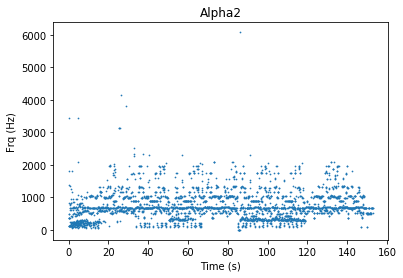

In [17]:
oblivion_spec = Spectrogram(12000, magnitudes)
create_spectrogram("Alpha2", oblivion_spec.bins)
oblivion_pairs = oblivion_spec.make_pairs_dict("oblivion", "lily potter")

In [28]:
import sys
sys.getsizeof(oblivion_spec)
getcontext()

Context(prec=7, rounding=ROUND_HALF_DOWN, Emin=-999999, Emax=999999, capitals=1, clamp=0, flags=[Inexact, FloatOperation, Rounded], traps=[InvalidOperation, DivisionByZero, Overflow])

In [29]:
sample_clip = AudioClip(sample, frq)
print(sample_clip)
sample_clip.low_pass(5000, 2 * 5000) # Cut at 5kHz
sample_clip.filter_and_downsample()
s_magnitudes, s_windows, s_results = sample_clip.create_frequencies_array()

Size 959488 sampled at 48000 Hz


/Users/kitty/miniconda3/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/Users/kitty/miniconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


387

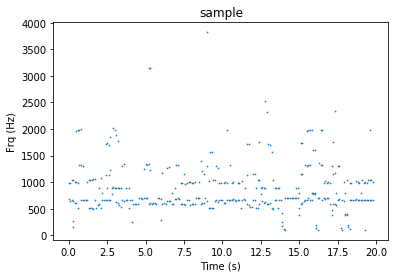

In [30]:
sample_spec = Spectrogram(12000, s_magnitudes)
create_spectrogram("sample", sample_spec.bins)

In [31]:
hit = 0
miss = 0
for address in sample_spec.make_pairs_dict("sample", "sample"):
    try:
        oblivion_pairs[address]
        print(address, oblivion_pairs[address])
        hit += 1
    except:
        miss += 1
print(hit, miss)

(Decimal('680.0'), Decimal('660.0'), Decimal('0.2')) (Decimal('63.9'), 'oblivion', 'lily potter')
(Decimal('680.0'), Decimal('1040.0'), Decimal('0.2')) (Decimal('72.0'), 'oblivion', 'lily potter')
(Decimal('680.0'), Decimal('160.0'), Decimal('0.3')) (Decimal('7.6'), 'oblivion', 'lily potter')
(Decimal('980.0'), Decimal('660.0'), Decimal('0.2')) (Decimal('71.6'), 'oblivion', 'lily potter')
(Decimal('980.0'), Decimal('1040.0'), Decimal('0.2')) (Decimal('67.4'), 'oblivion', 'lily potter')
(Decimal('980.0'), Decimal('160.0'), Decimal('0.3')) (Decimal('8.9'), 'oblivion', 'lily potter')
(Decimal('980.0'), Decimal('640.0'), Decimal('0.3')) (Decimal('45.3'), 'oblivion', 'lily potter')
(Decimal('640.0'), Decimal('1040.0'), Decimal('0.1')) (Decimal('20.1'), 'oblivion', 'lily potter')
(Decimal('640.0'), Decimal('640.0'), Decimal('0.2')) (Decimal('32.6'), 'oblivion', 'lily potter')
(Decimal('640.0'), Decimal('1040.0'), Decimal('0.2')) (Decimal('65.2'), 'oblivion', 'lily potter')
(Decimal('980.0'),

highhorse kaceymusgraves


/Users/kitty/miniconda3/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/Users/kitty/miniconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


5272 0
creep radiohead
2726 5272
welcometotheblackparade mychemicalromance
6270 7029
niceforwhat drake
10716 11219
pleasetellrosie allefarben
4400 20897
everydaystruggle biggie
4981 23435
trouble cagetheelephant
4871 26194
puzzlepieces saintmotel
5154 27937
brave sarabareilles
4903 29858
od britneystoney
3253 31667
somewhereovertherainbow iz
3770 32531
duality slipknot
4589 34200
.DS_Store Unable to read file
101 walla
3084 35718
rocketman eltonjohn
5371 36190
stoletheshow kygo
8318 38064
thedifference flume
3566 41982
oblivion lilypotter
3726 43368
clairdelune debussy
3044 44106
bluebird mirandalambert
4106 45034
bodylikeabackroad samhunt
3783 45861
soberup ajr
4230 46783
mercury ghostemane
2514 47697
whiteiverson postmalone
4709 49205
dontstopmenow queen
5665 50966
sendmylove adele
3830 53078
sowhat milesdavis
12698 53779
smellsliketeenspirit nirvana
4866 59480
youmeandthebourgeoisie thesubmarines
5927 60653
thunderstruck acdc
4834 62516
buffalosoldier bobmarley
4361 64746
littleslic

{(Decimal('100.0'), Decimal('1000.0'), Decimal('0.0')): (Decimal('110.3'),
  'stolendance',
  'milkychance'),
 (Decimal('100.0'), Decimal('120.0'), Decimal('0.1')): (Decimal('129.2'),
  'ijustcalledtosayiloveyou',
  'steviewonder'),
 (Decimal('100.0'), Decimal('220.0'), Decimal('0.1')): (Decimal('144.1'),
  'ijustcalledtosayiloveyou',
  'steviewonder'),
 (Decimal('100.0'), Decimal('140.0'), Decimal('0.2')): (Decimal('112.7'),
  'ijustcalledtosayiloveyou',
  'steviewonder'),
 (Decimal('100.0'), Decimal('80.0'), Decimal('0.3')): (Decimal('96.3'),
  'neededme',
  'rihanna'),
 (Decimal('380.0'), Decimal('120.0'), Decimal('0.1')): (Decimal('69.9'),
  'ijustcalledtosayiloveyou',
  'steviewonder'),
 (Decimal('380.0'), Decimal('220.0'), Decimal('0.1')): (Decimal('38.0'),
  'singsingsing',
  'bennygoodman'),
 (Decimal('380.0'), Decimal('140.0'), Decimal('0.2')): (Decimal('83.9'),
  'canttakemyeyesoffofyou',
  'frankievalli'),
 (Decimal('380.0'), Decimal('80.0'), Decimal('0.3')): (Decimal('44.3'

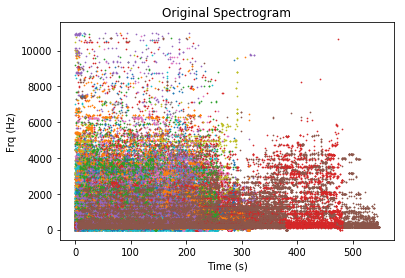

In [36]:
def build_database(path='./songs', outfile='./database/database.pickle'):
    database = {}
    for song_path in os.listdir(path):
        try:
            frq, raw_sample = read(os.path.join(path, song_path))
        except:
            print(song_path, "Unable to read file")
            continue
        title, artist, wav = song_path.split('.')
        print(title, artist)
        original = stereo_to_mono(raw_sample)
        ac = AudioClip(original, frq)
        ac.low_pass(5000, 2 * 5000) # Cut at 5kHz
        ac.filter_and_downsample()
        magnitudes, windowed_snippets, results = ac.create_frequencies_array()
        original_spec = Spectrogram(12000, magnitudes)
        create_spectrogram("Original Spectrogram", original_spec.bins)
        original_pairs = original_spec.make_pairs_dict(title, artist)
        print(len(original_pairs), len(database))
        database.update(original_pairs)
        with open(outfile, 'wb') as oh:
            pickle.dump(database, oh)
    return database
        
build_database()

In [39]:
def read_database(path='./database/database.pickle'):
    with open(path, 'rb') as oh:
        database = pickle.load(oh)
        return database
db = read_database()


In [40]:
def count_hits(database):
    hits = []
    miss = 0
    for address in sample_spec.make_pairs_dict("sample", "sample"):
        try:
            hits.append(database[address])
            print(address, database[address])
        except:
            miss += 1
    print(hit, miss)
    return hits
hits = count_hits(db)

(Decimal('680.0'), Decimal('980.0'), Decimal('0.1')) (Decimal('45.9'), 'jessiesgirl', 'rickspringfield')
(Decimal('680.0'), Decimal('660.0'), Decimal('0.2')) (Decimal('65.8'), 'ijustcalledtosayiloveyou', 'steviewonder')
(Decimal('680.0'), Decimal('1040.0'), Decimal('0.2')) (Decimal('77.1'), 'canttakemyeyesoffofyou', 'frankievalli')
(Decimal('680.0'), Decimal('160.0'), Decimal('0.3')) (Decimal('93.8'), 'canttakemyeyesoffofyou', 'frankievalli')
(Decimal('680.0'), Decimal('260.0'), Decimal('0.3')) (Decimal('75.4'), 'jessiesgirl', 'rickspringfield')
(Decimal('980.0'), Decimal('660.0'), Decimal('0.2')) (Decimal('2.8'), 'stayhigh', 'brittanyhoward')
(Decimal('980.0'), Decimal('1040.0'), Decimal('0.2')) (Decimal('91.4'), 'ijustcalledtosayiloveyou', 'steviewonder')
(Decimal('980.0'), Decimal('160.0'), Decimal('0.3')) (Decimal('89.8'), 'ijustcalledtosayiloveyou', 'steviewonder')
(Decimal('980.0'), Decimal('260.0'), Decimal('0.3')) (Decimal('10.7'), 'ilikethat', 'janellemonae')
(Decimal('980.0')

In [42]:
from collections import Counter
def analyze_hits(hits, num_results=5):
    matches = Counter()
    for hit in hits:
        absolute_time, title, artist = hit
        matches[title, artist] += 1
    return matches.most_common(num_results)
analyze_hits(hits)
    

[(('ijustcalledtosayiloveyou', 'steviewonder'), 108),
 (('oblivion', 'lilypotter'), 83),
 (('jessiesgirl', 'rickspringfield'), 61),
 (('neededme', 'rihanna'), 51),
 (('iwanttoholdyourhand', 'thebeatles'), 49)]